In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import fit_time_dep_fluxes as fit_flux
import os

import matplotlib
#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)


In [2]:
plotpath = './figures/'
if not os.path.isdir(plotpath):
    os.makedirs(plotpath)


In [3]:
#generate some synthetic data

np.random.seed(101)

n_reads = 42
n_pixels = 100

#set the read noise in each pixel
read_errs = ((np.random.rand(n_pixels)-0.5)*2)*5 + 28

#define true fluxes in each pixel
true_flux_dict = {
    'high':((np.random.rand(n_pixels)-0.5)*2)*200 + 1000,
    'mid':((np.random.rand(n_pixels)-0.5)*2)*50 + 100,
    'low':((np.random.rand(n_pixels)-0.5)*2)*2 + 5,
}

#define the true multiplicative factor to the fluxes
true_b_vect = np.ones(n_reads-1)*1.0
true_b_vect = np.linspace(0.5,2.0,n_reads-1)
true_b_vect[n_reads//2:] = 1.0
true_b_vect /= true_b_vect.max()

true_b_vect = 1.0 - (np.random.rand(n_reads-1))*0.5

read_times = np.arange(n_reads)
read_diff_times = 0.5*(read_times[1:]+read_times[:-1])

#hard-to-measure low fluxes to be used with b vectors
test_low_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*2 + 5


In [4]:

#number of times to redraw the data using the same true_b_vect, true_fluxes, read_errs
n_sim = 1000

results_dict = {}

for flux_level_ind,flux_level in enumerate(true_flux_dict):
    
    true_fluxes = true_flux_dict[flux_level]

    print(f'Fitting {n_sim} simulations of {flux_level} flux level data:')
    
    for s_ind,_ in enumerate(tqdm(np.arange(n_sim),total=n_sim)):
    
        np.random.seed((n_sim+1)*flux_level_ind+s_ind)
    
        #draw new data
        obs_fluxes = fit_flux.generate_data(read_errs,true_fluxes,true_b_vect)
        obs_fluxes_errs = np.sqrt(np.power(read_errs,2)+np.maximum(true_fluxes,0))
        obs_flux_diffs = np.diff(obs_fluxes,axis=1)
        # obs_flux_diff_errs = np.sqrt((read_err*2)**2+np.maximum(true_fluxes[:,1:],0))
        obs_flux_diff_errs = np.sqrt(np.power(read_errs*2,2)[:,None]+np.maximum(obs_flux_diffs,0))
    
        max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
                f_max_means_given_b,f_max_ivars_given_b,\
                comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
                                                               n_max_repeat=1000,b_vect_change_tol=1e-10,
                                                               min_b_val=1e-10,min_f_val=1e-10,
                                                               rescale=True,true_b_vect=true_b_vect,
                                                               true_fluxes=true_fluxes)
    
        
        non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
        non_max_inds[max_b_ind] = False
        non_max_inds = np.where(non_max_inds)[0]
        
        b_vect_errs = np.sqrt(np.diag(b_vect_V))
        f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

        f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                       n_repeat=2,b_vect=None)
        f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)

        test_low_obs_fluxes = fit_flux.generate_data(read_errs,test_low_fluxes,true_b_vect)
        
        low_flux_f_means_no_b,\
                low_flux_f_ivars_no_b,\
                low_flux_chi2s_data_no_b = fit_flux.fit_fluxes_optimal(test_low_obs_fluxes,read_errs,
                                                                       n_repeat=2,b_vect=None)
        low_flux_f_means_with_b,\
                low_flux_f_ivars_with_b,\
                low_flux_chi2s_data_with_b = fit_flux.fit_fluxes_optimal(test_low_obs_fluxes,read_errs,
                                                                         n_repeat=2,b_vect=b_vect_mean)
        
        if s_ind == 0:
            max_b_inds = np.zeros(n_sim).astype(int)
            b_vect_means = np.zeros((n_sim,*b_vect_mean.shape))
            b_vect_Vinvs = np.zeros((n_sim,*b_vect_Vinv.shape))
            b_vect_Vs = np.zeros((n_sim,*b_vect_V.shape))
            f_max_means_given_bs = np.zeros((n_sim,*f_max_means_given_b.shape))
            f_max_ivars_given_bs = np.zeros((n_sim,*f_max_ivars_given_b.shape))
            all_comb_param_means = np.zeros((n_sim,*comb_param_means.shape))
            all_comb_param_Vinvs = np.zeros((n_sim,*comb_param_Vinv.shape))
            all_comb_param_Vs = np.zeros((n_sim,*comb_param_V.shape))
            all_non_max_inds = np.zeros((n_sim,*non_max_inds.shape))
            all_b_vect_errs = np.zeros((n_sim,*b_vect_errs.shape))
            all_f_max_errs_given_bs = np.zeros((n_sim,*f_max_errs_given_b.shape))    
            
            all_f_max_zscores = np.zeros((n_sim,n_pixels))
            all_f_max_chi2s = np.zeros((n_sim))
            all_f_given_b_zscores = np.zeros((n_sim,n_pixels))
            all_f_given_b_chi2s = np.zeros((n_sim))
            
            all_b_vect_zscores = np.zeros((n_sim,n_reads-2))
            all_b_vect_chi2s = np.zeros((n_sim))
    
            all_comb_param_zscores = np.zeros((n_sim,len(comb_param_means)))
            all_comb_param_chi2s = np.zeros((n_sim))

            all_chi2s_data_no_bs = np.zeros((n_sim,*chi2s_data_no_b.shape))
            all_chi2s_data_with_bs = np.zeros((n_sim,*chi2s_data_with_b.shape))
            all_low_flux_chi2s_data_no_bs = np.zeros((n_sim,*low_flux_chi2s_data_no_b.shape))
            all_low_flux_chi2s_data_with_bs = np.zeros((n_sim,*low_flux_chi2s_data_with_b.shape))

    
        #save outputs, compare to truth, save summary statistics (like z-scores and chi2s)
        true_param_means = np.zeros_like(comb_param_means)
        true_param_means[:n_pixels] = true_fluxes
        true_param_means[n_pixels:] = true_b_vect[non_max_inds]
    
        max_b_inds[s_ind] = max_b_ind
        b_vect_means[s_ind] = b_vect_mean
        b_vect_Vinvs[s_ind] = b_vect_Vinv
        b_vect_Vs[s_ind] = b_vect_V
        f_max_means_given_bs[s_ind] = f_max_means_given_b
        f_max_ivars_given_bs[s_ind] = f_max_ivars_given_b
        all_comb_param_means[s_ind] = comb_param_means
        all_comb_param_Vinvs[s_ind] = comb_param_Vinv
        all_comb_param_Vs[s_ind] = comb_param_V
        all_non_max_inds[s_ind] = non_max_inds
        all_b_vect_errs[s_ind] = b_vect_errs
        all_f_max_errs_given_bs[s_ind] = f_max_errs_given_b
    
        all_b_vect_zscores[s_ind] = (b_vect_mean[non_max_inds]-true_b_vect[non_max_inds])/b_vect_errs[non_max_inds]
        all_f_max_zscores[s_ind] = (comb_param_means[:n_pixels]-true_fluxes)/np.sqrt(np.diag(comb_param_V)[:n_pixels])
        all_f_given_b_zscores[s_ind] = (f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b)
        all_f_given_b_chi2s[s_ind] = np.sum(np.power(all_f_given_b_zscores[s_ind],2))
        all_comb_param_zscores[s_ind] = (comb_param_means-true_param_means)/np.sqrt(np.diag(comb_param_V))
        
        diff = comb_param_means-true_param_means
        all_comb_param_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv,diff))
        diff = (comb_param_means-true_param_means)[n_pixels:]
        all_b_vect_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv[n_pixels:,n_pixels:],diff))
        diff = (comb_param_means-true_param_means)[:n_pixels]
        all_f_max_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv[:n_pixels,:n_pixels],diff))

        all_chi2s_data_no_bs[s_ind] = chi2s_data_no_b
        all_chi2s_data_with_bs[s_ind] = chi2s_data_with_b
        all_low_flux_chi2s_data_no_bs[s_ind] = low_flux_chi2s_data_no_b
        all_low_flux_chi2s_data_with_bs[s_ind] = low_flux_chi2s_data_with_b
    
    results_dict[flux_level] = {
        'all_b_vect_zscores':all_b_vect_zscores,
        'all_f_max_zscores':all_b_vect_zscores,
        'all_f_given_b_zscores':all_f_given_b_zscores,
        'all_f_given_b_chi2s':all_f_given_b_chi2s,
        'all_comb_param_zscores':all_comb_param_zscores,
        'all_comb_param_chi2s':all_comb_param_chi2s,
        'all_b_vect_chi2s':all_b_vect_chi2s,
        'all_f_max_chi2s':all_f_max_chi2s,
        'all_chi2s_data_no_bs':all_chi2s_data_no_bs,
        'all_chi2s_data_with_bs':all_chi2s_data_with_bs,
        'all_low_flux_chi2s_data_no_bs':all_low_flux_chi2s_data_no_bs,
        'all_low_flux_chi2s_data_with_bs':all_low_flux_chi2s_data_with_bs,
    }
    
    print('Done')


Fitting 1000 simulations of high flux level data:


100%|███████████████████████████████████████| 1000/1000 [06:39<00:00,  2.50it/s]


Done
Fitting 1000 simulations of mid flux level data:


100%|███████████████████████████████████████| 1000/1000 [08:40<00:00,  1.92it/s]


Done
Fitting 1000 simulations of low flux level data:


100%|███████████████████████████████████████| 1000/1000 [25:37<00:00,  1.54s/it]

Done


In [5]:

lw = 2
alpha = 1.0
cumulative = True


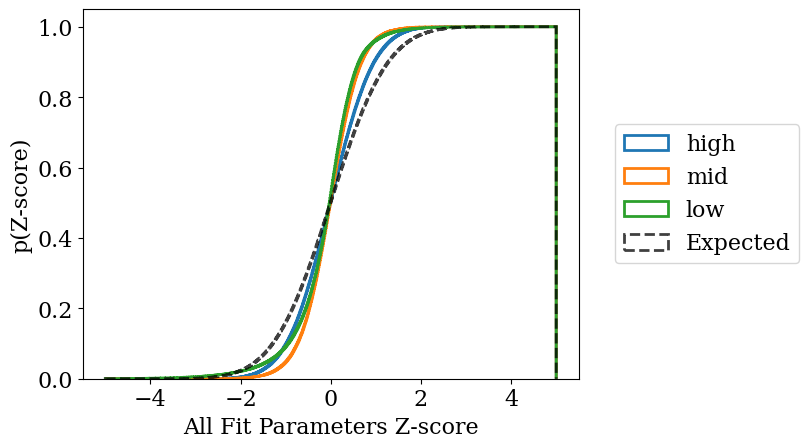

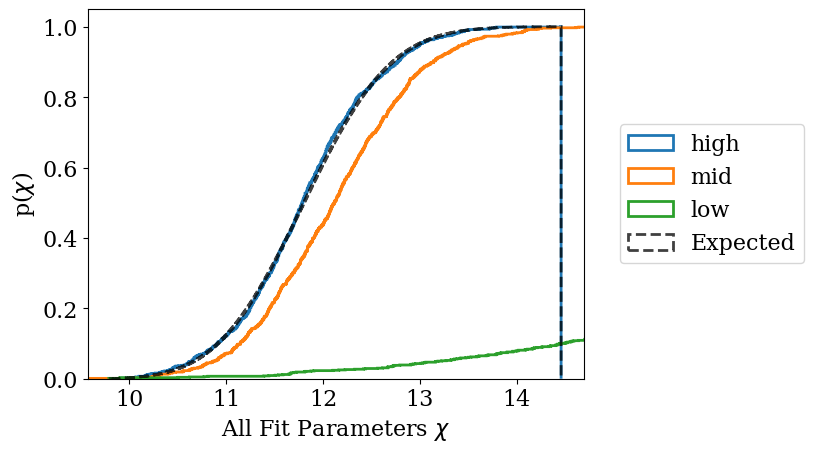

In [6]:

for flux_level_ind,flux_level in enumerate(results_dict):
    all_comb_param_zscores = results_dict[flux_level]['all_comb_param_zscores']
    hist = plt.hist(np.ravel(all_comb_param_zscores),
                    histtype='step',cumulative=cumulative,
                    density=True,bins=1000,range=[-5,5],
                    label=flux_level,lw=lw,alpha=alpha)

hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'All Fit Parameters Z-score')
plt.ylabel(r'p(Z-score)')
plt.show()


for flux_level_ind,flux_level in enumerate(results_dict):
    all_comb_param_chi2s = results_dict[flux_level]['all_comb_param_chi2s']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_comb_param_chi2s)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_comb_param_chi2s),
                        label=flux_level,lw=lw,alpha=alpha)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_comb_param_chi2s)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_comb_param_chi2s)*100,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=flux_level,lw=lw,alpha=alpha)
        
plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,
                                   df=all_comb_param_zscores.shape[1]).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'All Fit Parameters $\chi$')
plt.ylabel(r'p($\chi$)')
plt.show()



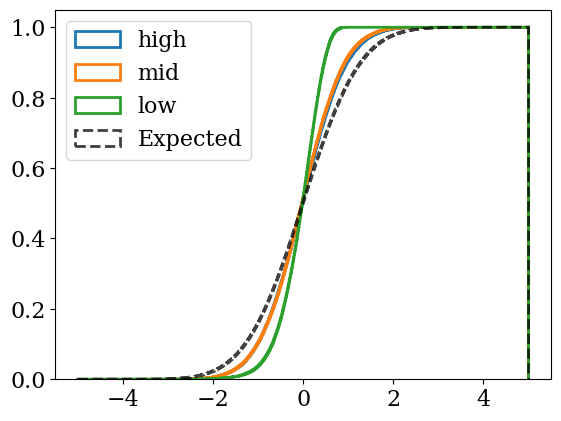

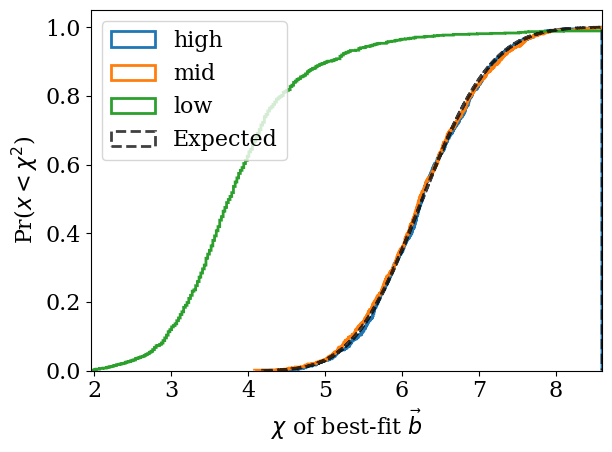

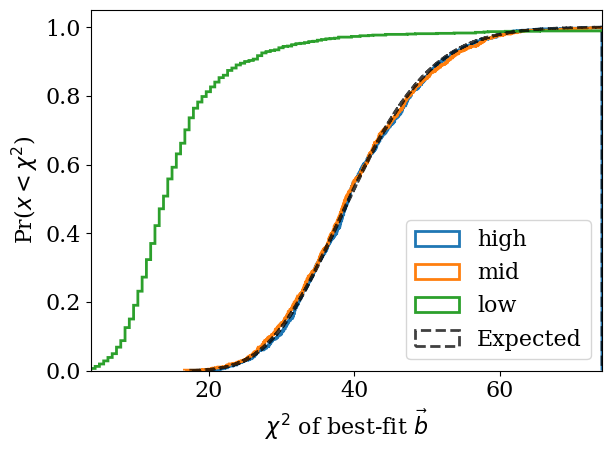

In [7]:

for flux_level_ind,flux_level in enumerate(results_dict):
    all_b_vect_zscores = results_dict[flux_level]['all_b_vect_zscores']
    hist = plt.hist(np.ravel(all_b_vect_zscores),
                    histtype='step',cumulative=cumulative,
                    density=True,bins=1000,range=[-5,5],
                    label=flux_level,lw=lw,alpha=alpha)

hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.show()


for flux_level_ind,flux_level in enumerate(results_dict):
    all_b_vect_chi2s = results_dict[flux_level]['all_b_vect_chi2s']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_b_vect_chi2s)),
                        histtype='step',cumulative=cumulative,
                        density=True,bins=np.size(all_b_vect_chi2s),
                        label=flux_level,lw=lw,alpha=alpha)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
        xlim = np.array([hist_bins[0],hist_bins[-1]])
        
    else:
        curr_hist = plt.hist(np.sqrt(np.ravel(all_b_vect_chi2s)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_b_vect_chi2s),
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=flux_level,lw=lw,alpha=alpha)
        xlim[0] = min(xlim[0],curr_hist[1][0])
plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'$\chi$ of best-fit $\vec b$')
plt.ylabel(r'Pr($x < \chi^2$)')
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_bvect_chi.png')
plt.show()


for flux_level_ind,flux_level in enumerate(results_dict):
    all_b_vect_chi2s = results_dict[flux_level]['all_b_vect_chi2s']
    if flux_level_ind == 0:
        hist = plt.hist(np.ravel(all_b_vect_chi2s),
                        histtype='step',cumulative=cumulative,
                        density=True,bins=np.size(all_b_vect_chi2s),
                        label=flux_level,lw=lw,alpha=alpha)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
        xlim = np.array([hist_bins[0],hist_bins[-1]])
        
    else:
        curr_hist = plt.hist(np.ravel(all_b_vect_chi2s),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_b_vect_chi2s),
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=flux_level,lw=lw,alpha=alpha)
        xlim[0] = min(xlim[0],curr_hist[1][0])
plt.xlim(xlim)
expect_weights = np.diff(stats.chi2(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'$\chi^2$ of best-fit $\vec b$')
plt.ylabel(r'Pr($x < \chi^2$)')
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_bvect_chi2.png')
plt.show()



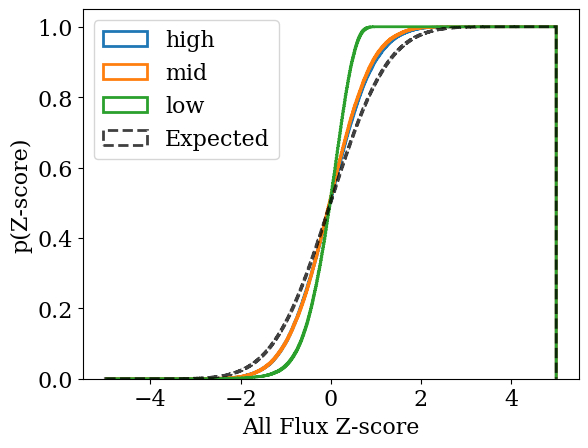

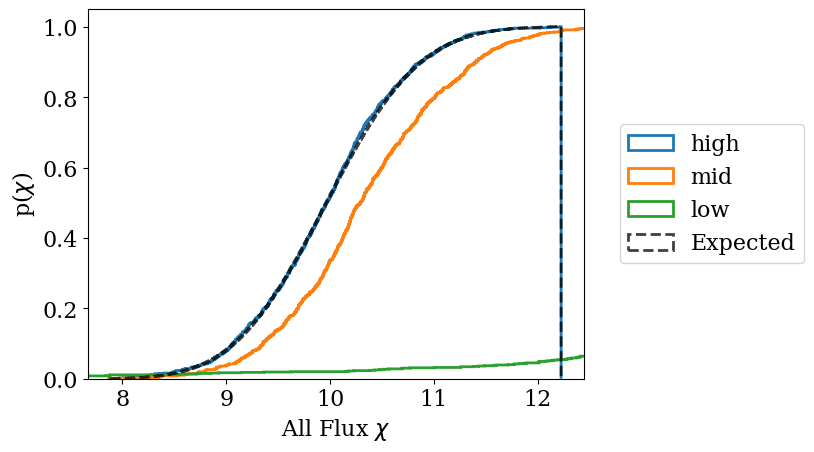

In [8]:

for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_max_zscores = results_dict[flux_level]['all_f_max_zscores']
    hist = plt.hist(np.ravel(all_f_max_zscores),
                    histtype='step',cumulative=cumulative,
                    density=True,bins=1000,range=[-5,5],
                    label=flux_level,lw=lw,alpha=alpha)

hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc='best')
plt.xlabel(r'All Flux Z-score')
plt.ylabel(r'p(Z-score)')
plt.show()


for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_max_chi2s = results_dict[flux_level]['all_f_max_chi2s']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_f_max_chi2s)),
                        histtype='step',cumulative=cumulative,
                        density=True,bins=np.size(all_f_max_chi2s),
                        label=flux_level,lw=lw,alpha=alpha)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_f_max_chi2s)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_f_max_chi2s)*100,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=flux_level,lw=lw,alpha=alpha)
plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_pixels).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'All Flux $\chi$')
plt.ylabel(r'p($\chi$)')
plt.show()



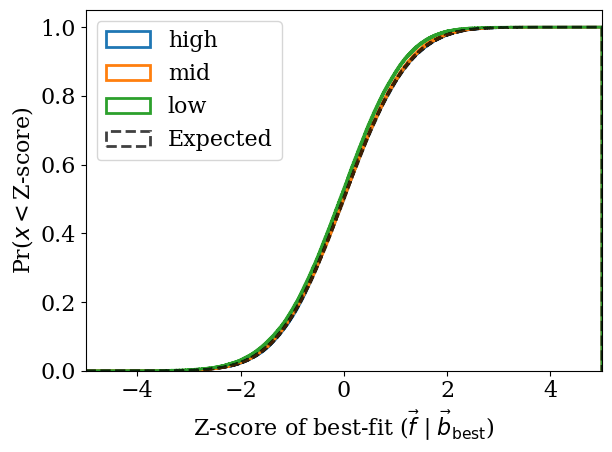

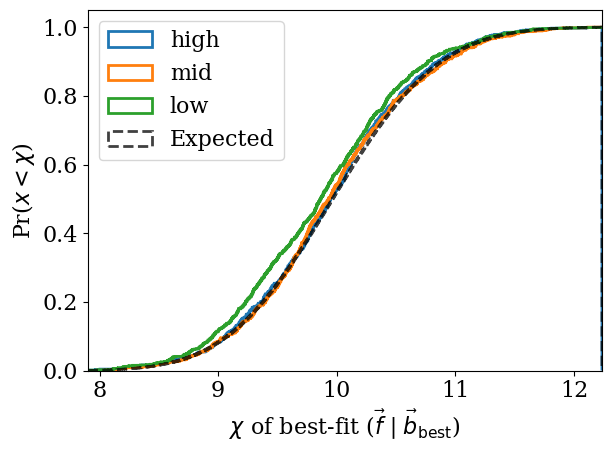

In [9]:

xlim = [-5,5]
for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_given_b_zscores = results_dict[flux_level]['all_f_given_b_zscores']
    hist = plt.hist(np.ravel(all_f_given_b_zscores),
                    histtype='step',cumulative=cumulative,
                    density=True,bins=1000,range=xlim,
                    label=flux_level,lw=lw,alpha=alpha)

hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,
         cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'Z-score of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
plt.ylabel(r'Pr($x < $Z-score)')
plt.xlim(xlim)
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_zscore.png')
plt.show()


for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_given_b_chi2s = results_dict[flux_level]['all_f_given_b_chi2s']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_f_given_b_chi2s),
                        label=flux_level,lw=lw,alpha=alpha)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
        xlim = hist_bins[0],hist_bins[-1]
    else:
        curr_hist_bin_min = min(np.nanmin(all_f_given_b_chi2s),hist_bins[0])
        curr_hist_bin_max = max(min(np.nanmax(all_f_given_b_chi2s),10*hist_bins[-1]),hist_bins[-1])
        curr_hist_bins = np.linspace(curr_hist_bin_min,curr_hist_bin_max,np.size(all_f_given_b_chi2s)*100)
        plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=curr_hist_bins,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=flux_level,lw=lw,alpha=alpha)
plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_pixels).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'$\chi$ of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
plt.ylabel(r'Pr($x < \chi$)')
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_chi.png')
plt.show()

In [10]:
np.linspace(curr_hist_bin_min,curr_hist_bin_max,np.size(all_f_given_b_chi2s)*100)

array([  7.90004755,   7.90119204,   7.90233653, ..., 122.34574646,
       122.34689095, 122.34803544])

In [11]:
curr_hist_bin_min

7.900047546186945

In [12]:
curr_hist_bin_max

122.3480354429403

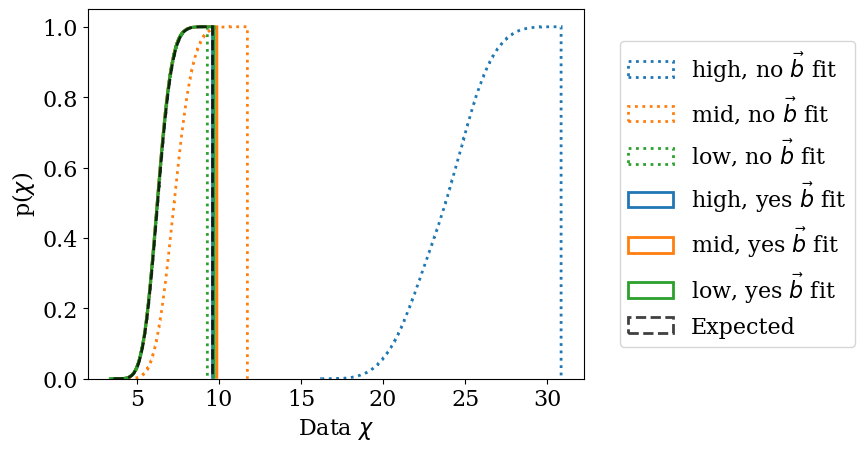

In [13]:

for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = ':'
    label = f'{flux_level}, '+r'no $\vec b$ fit'
    all_chi2s_data_no_bs = results_dict[flux_level]['all_chi2s_data_no_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_chi2s_data_no_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_chi2s_data_no_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_chi2s_data_no_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_chi2s_data_no_bs),
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)
        
for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = '-'
    label = f'{flux_level}, '+r'yes $\vec b$ fit'
    all_chi2s_data_with_bs = results_dict[flux_level]['all_chi2s_data_with_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_chi2s_data_with_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_chi2s_data_with_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_chi2s_data_with_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_chi2s_data_with_bs),
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)


# plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'Data $\chi$')
plt.ylabel(r'p($\chi$)')
plt.show()


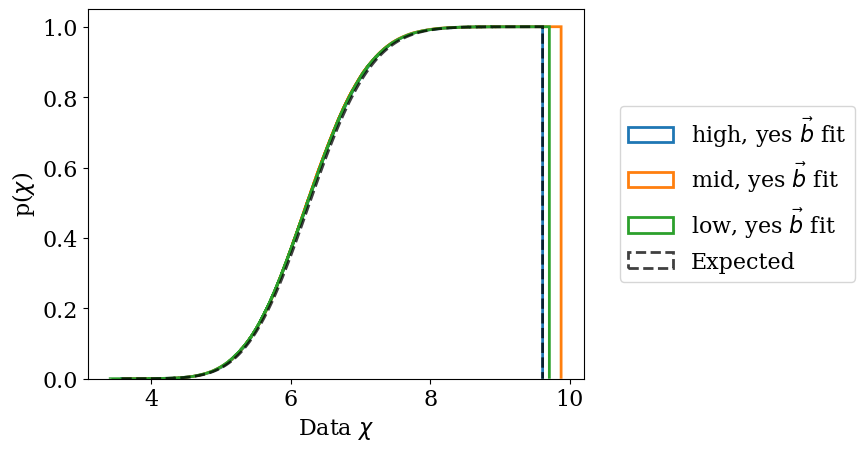

In [14]:
for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = '-'
    label = f'{flux_level}, '+r'yes $\vec b$ fit'
    all_chi2s_data_with_bs = results_dict[flux_level]['all_chi2s_data_with_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_chi2s_data_with_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_chi2s_data_with_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_chi2s_data_with_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_chi2s_data_with_bs)*100,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)


# plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'Data $\chi$')
plt.ylabel(r'p($\chi$)')
plt.show()


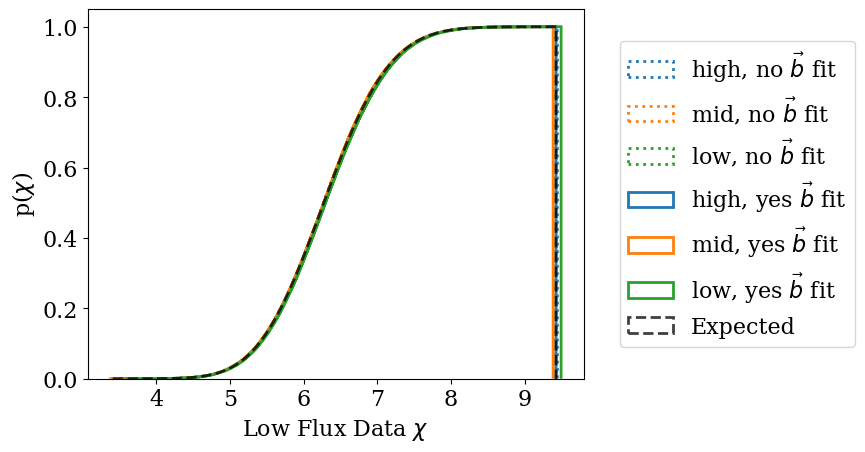

In [15]:

for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = ':'
    label = f'{flux_level}, '+r'no $\vec b$ fit'
    all_low_flux_chi2s_data_no_bs = results_dict[flux_level]['all_low_flux_chi2s_data_no_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_low_flux_chi2s_data_no_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_low_flux_chi2s_data_no_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_low_flux_chi2s_data_no_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_low_flux_chi2s_data_no_bs)*100,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)
        
for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = '-'
    label = f'{flux_level}, '+r'yes $\vec b$ fit'
    all_low_flux_chi2s_data_with_bs = results_dict[flux_level]['all_low_flux_chi2s_data_with_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_low_flux_chi2s_data_with_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_low_flux_chi2s_data_with_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_low_flux_chi2s_data_with_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_low_flux_chi2s_data_with_bs)*100,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)


# plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'Low Flux Data $\chi$')
plt.ylabel(r'p($\chi$)')
plt.show()
